# Project 4: West Nile Virus - Modelling

---
# Table of Contents

1. Import libraries
2. Import data
3. TBC
4. TBC
---


# Import libraries

In [103]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector


from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier,\
GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, recall_score, precision_score, \
roc_auc_score, plot_roc_curve, roc_curve, plot_confusion_matrix, accuracy_score,\
f1_score,ConfusionMatrixDisplay, RocCurveDisplay

# import warnings
# warnings.simplefilter("ignore")

# Import data

In [23]:
#import training dataset
train = pd.read_csv('../output_data/merged_train.csv')

In [24]:
#data cleaning
train.set_index('date', inplace=True)
train.drop(columns='nummosquitos', inplace=True)

In [ ]:
#check the df cloumns
print(f'Features in training set : {train.columns.tolist()}')

In [27]:
# define feature matrix and target vector
X = train.drop(columns='wnvpresent')
y = train['wnvpresent']

# Preprocessing 

## Train-validation  split

In [29]:
#split dataset into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  random_state = 42,
                                                  shuffle=False)  ### to double check

In [30]:
#check the shape of training and testing vectors 
print(f'shape of the training matrix X:        {X_train.shape}')
print(f'shape of the training target vector y: {y_train.shape}')
print('========================')
print(f'shape of the validate matrix X:        {X_val.shape}')
print(f'shape of the validate vector y:        {y_val.shape}')

shape of the training matrix X:        (7879, 15)
shape of the training target vector y: (7879,)
shape of the validate matrix X:        (2627, 15)
shape of the validate vector y:        (2627,)


## Data transformation 

In [31]:
#instantiate transformers 
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
sc = StandardScaler()


#instantite transformer into col transformer 
ct = make_column_transformer(
    (sc, make_column_selector(dtype_include='number')),
    (ohe, make_column_selector(dtype_exclude='number')),
    remainder='passthrough', 
    verbose_feature_names_out=False
)

#transform feature matrix
X_train = pd.DataFrame(ct.fit_transform(X_train), 
                       columns=ct.get_feature_names_out())

X_val = pd.DataFrame(ct.transform(X_val), 
                       columns=ct.get_feature_names_out())

In [32]:
#check X matrix after transformation
X_train.head()

,latitude,longitude,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,temp_fluct,daylight,relative_hum,species_PIPIENS,species_PIPIENS/RESTUANS,species_RESTUANS,species_SALINARIUS,species_TARSALIS,species_TERRITANS
0,1.048499,-1.102591,0.686175,-0.237569,0.258132,1.037898,-0.256308,0.011419,-0.320708,0.19251,-0.426247,1.367454,0.883993,-0.909542,0.0,1.0,0.0,0.0,0.0,0.0
1,1.048499,-1.102591,0.686175,-0.237569,0.258132,1.037898,-0.256308,0.011419,-0.320708,0.19251,-0.426247,1.367454,0.883993,-0.909542,0.0,0.0,1.0,0.0,0.0,0.0
2,1.403478,-0.771693,0.686175,-0.237569,0.258132,1.037898,-0.256308,0.011419,-0.320708,0.19251,-0.426247,1.367454,0.883993,-0.909542,0.0,0.0,1.0,0.0,0.0,0.0
3,1.219370,-1.351150,0.686175,-0.237569,0.258132,1.037898,-0.256308,0.011419,-0.320708,0.19251,-0.426247,1.367454,0.883993,-0.909542,0.0,1.0,0.0,0.0,0.0,0.0
4,1.219370,-1.351150,0.686175,-0.237569,0.258132,1.037898,-0.256308,0.011419,-0.320708,0.19251,-0.426247,1.367454,0.883993,-0.909542,0.0,0.0,1.0,0.0,0.0,0.0


In [80]:
#check the df cloumns
print(f'Features in X matrix: {X_train.columns.tolist()}')

Index(['latitude', 'longitude', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'temp_fluct', 'daylight',
       'relative_hum', 'species_PIPIENS', 'species_PIPIENS/RESTUANS',
       'species_RESTUANS', 'species_SALINARIUS', 'species_TARSALIS',
       'species_TERRITANS'],
      dtype='object')

In [33]:
#check the shape of training and testing vectors 
print(f'shape of the training matrix X:          {X_train.shape}')
print(f'shape of the training target vector y:   {y_train.shape}')
print('========================')
print(f'shape of the validation matrix X:        {X_val.shape}')
print(f'shape of the validation vector vector y: {y_val.shape}')

shape of the training matrix X:          (7879, 20)
shape of the training target vector y:   (7879,)
shape of the validation matrix X:        (2627, 20)
shape of the validation vector vector y: (2627,)


# Modelling

Create a modelling function that allows us to run all the models

In [314]:
def modeller(clf, params):
    gs = GridSearchCV(clf, params, cv=5, n_jobs=-1, scoring= "roc_auc").fit(X_train, y_train)
    gs.fit(X_train, y_train)
    
    y_pred = gs.predict(X_val)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
   
    accuracy = (tn + fn) / (tn + fp + fn + tp)
    spec = tn/ (tn + fp)
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f1 = 2*((precision*recall)/(precision+recall))
    roc = roc_auc_score(y_val, gs.predict_proba(X_val)[:,1])
        
    df = pd.DataFrame([[f"{clf}", accuracy, spec, recall, precision, f1, fp, fn, roc]], columns = ["Model Name",
                                                                "Accuracy", "Specificity", "Recall", "Precision", "F1", "False Positives", "False Negatives", "ROC-AUC"])
    
    display(df)
    
    return gs
    #scoring

## Dummy model

In [46]:
#fit dummy model
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

#print result
print(f'score from training: {dummy_clf.score(X_train, y_train)}')
print(f'score from testing:  {dummy_clf.score(X_val, y_val)}')


#compute predicted values with testing set
y_pred =  dummy_clf.predict(X_val)

#compute confusion matrix from testing set
cm0 = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = cm0.ravel()

#save the output as dictionary
model0 = {}
model0['accuracy'] = accuracy_score(y_val, y_pred)
model0['precision'] = precision_score(y_val, y_pred)
model0['recall'] = recall_score(y_val, y_pred)
model0['specificity'] = tn / (tn+fp)
model0['f1'] = f1_score(y_val, y_pred)

#print result
print(f'dummy classifier score: {model0}')

#print confusion matrix 
disp = ConfusionMatrixDisplay(cm0)
disp.plot(cmap='Blues');

DummyClassifier(random_state=42, strategy='most_frequent')

In [29]:
# Baseline
y.value_counts(normalize=True)

0    0.947554
1    0.052446
Name: wnvpresent, dtype: float64

## Random forest classifier

In [86]:
#rfc

rfc_params = {"n_estimators": [10, 50, 100, 250], 
             "max_depth": [5, 10, 20],
             "class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}
rfc = modeller(RandomForestClassifier(random_state = 42), rfc_params)

,Model Name,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
0,RandomForestClassifier(random_state=42),0.826037,0.854981,0.451613,0.245077,0.31773,345,136,0.653297


## Support vector classifier

In [91]:
#svc

svc_params = {"C": [10**-2, 10**-1, 10**0, 10**1, 10**2],
             "class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]}
svc = modeller(SVC(probability = True, random_state = 42), svc_params)

,Model Name,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
0,"SVC(probability=True, random_state=42)",0.808907,0.822615,0.322581,0.159363,0.213333,422,168,0.572598


## Logistic regression

In [92]:
lr_params = {}
lr_params["C"] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
lr_params["penalty"] = ['l1', 'l2']
lr_params["class_weight"] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]

lr = modeller(LogisticRegression(random_state = 42), lr_params)

,Model Name,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
0,LogisticRegression(random_state=42),1.0,1.0,0.0,NaN,NaN,0,248,0.5


## K-nearest neighbour

In [97]:
knn_params = {}
knn_params["n_neighbors"] = [2,5,10,25,50]

knn = modeller(KNeighborsClassifier(), knn_params)

,Model Name,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
0,KNeighborsClassifier(),1.0,1.0,0.0,NaN,NaN,0,248,0.5


## Gradient boosting classifier

In [94]:
gbc_params = {}
gbc_params["n_estimators"] = [10, 50, 100, 250]
gbc_params["max_depth"] = [5, 10, 20]

gbc = modeller(GradientBoostingClassifier(random_state = 42), gbc_params)

,Model Name,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
0,GradientBoostingClassifier(random_state=42),0.995813,0.996637,0.012097,0.272727,0.023166,8,245,0.504367


## XGB classifier

In [ ]:
xgb_params = {"use_label_encoder": [False],
              "objective": ["binary:logistic"],
              "eval_metric": ['auc'],
              "learning_rate":[0.1, 0.2, 0.5],
              "max_depth": [5,8],
              "max_leaf_nodes": [None,], #tune params
              "gamma": np.linspace(5, 100, 8),
              "reg_alpha": np.linspace(0.0001, 1, 8),
              "reg_lambda": np.linspace(5, 100, 5)} #tune params

xgb = modeller(XGBClassifier(random_state = 42), xgb_params)

In [ ]:
np.linspace(0.0001, 1, 8)

In [ ]:
xgb.best_params_

In [60]:
# xgb_params = {"eta": np.linspace(0.001, 0.2, 20),
#              "max_depth": [4,5,6,7,8,9,10],
#              "max_leaf_nodes": [None, ], #tune params
#              "gamma": np.linspace(0, 10, 10),
#              "reg_alpha": np.linspace(0.001, 1000, 10),
#              "reg_lambda": np.linspace(0, 10, 10)} #tune params

# modeller(XGBClassifier(random_state = 42), xgb_params)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[20:57:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:57:44] WARNING: /Users/runner/miniforge3/cond

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[20:58:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:32] WARNING: /Users/runner/miniforge3/cond

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[20:58:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:34] WARNING: /Users/runner/miniforge3/cond

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[20:58:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:58:35] WARNING: /Users/runner/miniforge3/cond

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[20:59:28] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:59:31] WARNING: /Users/runner/miniforge3/cond

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[21:00:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1643227205751/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:00:32] WARNING: /Users/runner/miniforge3/cond

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

KeyboardInterrupt: 

## Extra trees ckassifier

In [95]:
et_params = {"max_depth": [4,5,6,7,8,9,10],
            "min_samples_leaf": [None, 2, 5, 10],
            "max_features": [None, 15, 20],
            "max_leaf_nodes": [None, 2, 5, 10, 15, 20]}

et = modeller(ExtraTreesClassifier(random_state = 42), et_params)

,Model Name,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
0,ExtraTreesClassifier(random_state=42),1.0,1.0,0.0,NaN,NaN,0,248,0.5


# Model evaluation

In [170]:
#code into a function

#make model names & models into a dict

models = [rfc, svc, lr, knn, gbc, xgb, et]

model_names = ["RFC", "SVC", "LR", "KNN", "GBC", "XGB", "ExtraTrees"]


## Scoring

In [192]:
#scoring function defined

def scorer(X_val, y_val, models,  model_names):  
    
    #zip models & model_names
    
    
    for index, model in enumerate(zip(model_names, models)):
    
        y_pred = model[1].predict(X_val)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
        spec = tn/ (tn + fp)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
        f1 = 2*((precision*recall)/(precision+recall))
        roc = roc_auc_score(y_val, model[1].predict_proba(X_val)[:,1])
        
        if index == 0:      
            df = pd.DataFrame([[model[0], model[1].best_score_, spec, recall, precision, f1, fp, fn, roc]], columns = ["Model Name",
                                                                                                                       "Accuracy", "Specificity", "Recall", "Precision", "F1", "False Positives", "False Negatives", "ROC-AUC"])
            
        else:
            metrics = [model[0], model[1].best_score_, spec, recall, precision, f1, fp, fn, roc]
                
            df = pd.concat([df, pd.DataFrame([metrics], columns = ["Model Name", "Accuracy", "Specificity",
                                                                 "Recall", "Precision", "F1",
                                                                 "False Positives", "False Negatives", "ROC-AUC"])], axis = 0)
            
    return df

In [193]:
scorer(X_val, y_val, models, model_names)

,Model Name,Accuracy,Specificity,Recall,Precision,F1,False Positives,False Negatives,ROC-AUC
0,RFC,0.566535,0.854981,0.451613,0.245077,0.317730,345,136,0.732405
0,SVC,0.605619,0.822615,0.322581,0.159363,0.213333,422,168,0.659562
0,LR,0.723681,1.000000,0.000000,NaN,NaN,0,248,0.764267
0,KNN,0.524037,1.000000,0.000000,NaN,NaN,0,248,0.640954
0,GBC,0.553549,0.996637,0.012097,0.272727,0.023166,8,245,0.762249
0,XGB,0.680401,1.000000,0.000000,NaN,NaN,0,248,0.765851
0,ExtraTrees,0.654633,1.000000,0.000000,NaN,NaN,0,248,0.710034


In [173]:
# def roc_plotter(models, df):
#     for index, model in enumerate(models):
    
#         y_pred = model.predict(X_val) # predict the test data
# # Compute False postive rate, and True positive rate
#         fpr, tpr, thresholds = roc_curve(y_val, y_pred)
# # Calculate Area under the curve to display on the plot
#         auc = roc_auc_score(y_val, y_pred)
# # Now, plot the computed values
#         plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (df["Model Name"].iloc[index], auc))
# # Custom settings for the plot 
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('1-Specificity(False Positive Rate)')
#     plt.ylabel('Sensitivity(True Positive Rate)')
#     plt.title('Receiver Operating Characteristic')
#     plt.legend(loc="lower right")
#     plt.show()

In [174]:
# roc_plotter(models, metrics)

## ROC plot

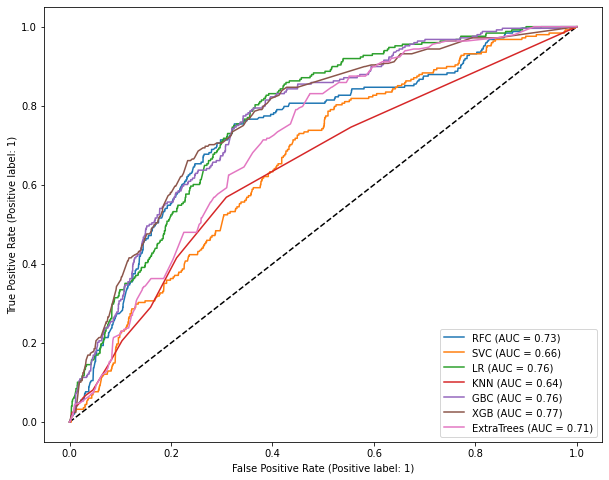

In [176]:
#plot ROC
fig, ax = plt.subplots(figsize=(10,8))
plt.plot([0, 1], [0, 1], "k--")
for i, model in enumerate(models):
    RocCurveDisplay.from_estimator(model,
                                   X_val,
                                   y_val,
                                   ax=ax,
                                   name=f'{model_names[i]}')

## Confusion matrices


In [188]:
#confusion matrix function 
def cm_plot(model, model_names, r, c):
    '''plot confusion matrix
    
    cm_list - list of confusion matrix
    gs_list - list of grid search model
    r - number of rows
    c - number of columns
    '''

    
    count = 0
    fig, axs = plt.subplots(nrows=r, ncols=c, figsize=(18, 15))
    for row in range(r):
        for col in range(c):
            y_pred = models[count].predict(X_val)
            disp = ConfusionMatrixDisplay(confusion_matrix(y_val, y_pred))
            axs[row,col].set_title(f'{model_names[count]}')
            disp.plot(cmap='Blues', ax=axs[row,col]);
            count += 1
            if count == len(models):
                break
                
    # delete empty axes with no data         
    for ax in axs.flat:
        if not bool(ax.has_data()):
            fig.delaxes(ax)

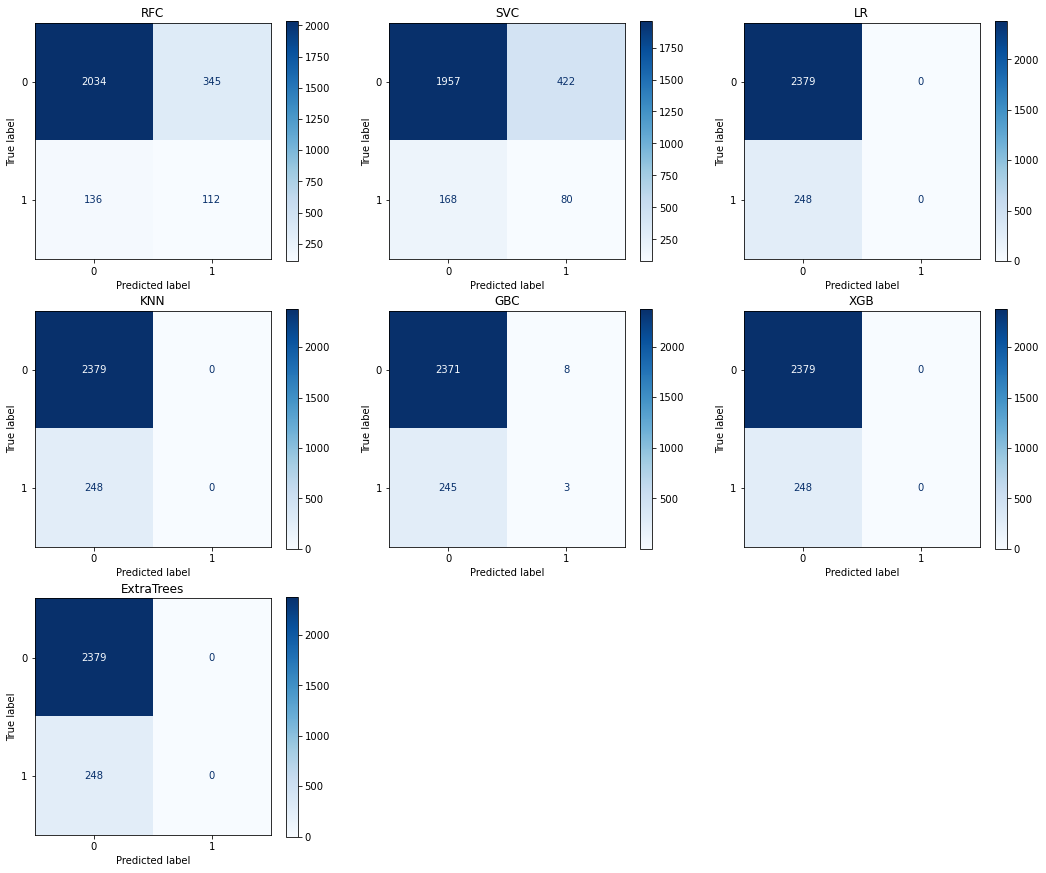

In [189]:
#plot confusion matrices 
cm_plot(model=model, model_names=model_names, r=3, c=3)

# Production model

## Cleaning test data set

In [246]:
test = pd.read_csv('project_4_west_nile_virus/input_data/test.csv')

In [247]:
test.columns = test.columns.str.lower()

In [248]:
test.head()

,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [249]:
from metpy.units import units
from metpy.calc import relative_humidity_from_dewpoint
weather_cleaned = pd.read_csv('project_4_west_nile_virus/output_data/weather_clean.csv')

In [250]:
weather_cleaned["temp_fluct"] = weather_cleaned["tmax"] - weather_cleaned["tmin"]

In [251]:
weather_cleaned['date'] = pd.to_datetime(weather_cleaned['date'])
weather_cleaned['year'] = weather_cleaned['date'].dt.year
weather_cleaned['mth_day'] = weather_cleaned['date'].dt.strftime("%m-%d")
weather_cleaned['week'] = weather_cleaned['date'].dt.isocalendar().week.astype(int)

In [252]:
#new feature - daylight
weather_cleaned['daylight'] = (weather_cleaned['sunset'].astype('datetime64') - 
                       weather_cleaned['sunrise'].astype('datetime64')).dt.seconds/3600

In [253]:
# function to calculate relative humidity
def cal_rh(temp, dewpoint):
    rh = relative_humidity_from_dewpoint(temperature= temp * units.fahrenheit, 
                                         dewpoint= dewpoint * units.fahrenheit).magnitude
    return rh

# new feature - relative_hum
weather_cleaned['relative_hum'] = weather_cleaned.apply(lambda x: cal_rh(x['tavg'], x['dewpoint']), axis =1)

In [254]:
weather_cleaned.date = weather_cleaned.date.astype('string')

In [255]:
test = test.merge(weather_cleaned.groupby('date').mean(), on='date', how='left')

In [256]:
test.columns

Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'station', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb',
       'heat', 'cool', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed',
       'resultdir', 'avgspeed', 'temp_fluct', 'year', 'week', 'daylight',
       'relative_hum'],
      dtype='object')

In [267]:
X_test = test[['species', 'latitude', 'longitude', 
              'tmax', 'tmin', 'tavg', 'depart', 
              'dewpoint', 'wetbulb', 'heat', 'cool',
              'preciptotal', 'temp_fluct', 'daylight', 'relative_hum']]

## Transforming test data

In [269]:
X_test = pd.DataFrame(ct.transform(X_test), 
                       columns=ct.get_feature_names_out())

In [271]:
X_test.head()

,latitude,longitude,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,preciptotal,temp_fluct,daylight,relative_hum,species_PIPIENS,species_PIPIENS/RESTUANS,species_RESTUANS,species_SALINARIUS,species_TARSALIS,species_TERRITANS
0,1.048499,-1.102591,0.438003,-0.10324,0.189625,0.577897,-0.655119,-0.220665,-0.320708,0.104682,-0.426247,0.805363,1.110867,-1.427189,0.0,0.0,0.0,0.0,0.0,0.0
1,1.048499,-1.102591,0.438003,-0.10324,0.189625,0.577897,-0.655119,-0.220665,-0.320708,0.104682,-0.426247,0.805363,1.110867,-1.427189,0.0,0.0,0.0,0.0,0.0,0.0
2,1.048499,-1.102591,0.438003,-0.10324,0.189625,0.577897,-0.655119,-0.220665,-0.320708,0.104682,-0.426247,0.805363,1.110867,-1.427189,0.0,0.0,0.0,0.0,0.0,0.0
3,1.048499,-1.102591,0.438003,-0.10324,0.189625,0.577897,-0.655119,-0.220665,-0.320708,0.104682,-0.426247,0.805363,1.110867,-1.427189,0.0,0.0,0.0,0.0,0.0,0.0
4,1.048499,-1.102591,0.438003,-0.10324,0.189625,0.577897,-0.655119,-0.220665,-0.320708,0.104682,-0.426247,0.805363,1.110867,-1.427189,0.0,0.0,0.0,0.0,0.0,0.0


In [272]:
X_test.columns

Index(['latitude', 'longitude', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'preciptotal', 'temp_fluct', 'daylight',
       'relative_hum', 'species_PIPIENS', 'species_PIPIENS/RESTUANS',
       'species_RESTUANS', 'species_SALINARIUS', 'species_TARSALIS',
       'species_TERRITANS'],
      dtype='object')

## Predict

In [278]:
xgb.predict_proba(X_test)

array([[0.9922678 , 0.00773223],
       [0.9922678 , 0.00773223],
       [0.9922678 , 0.00773223],
       ...,
       [0.98520344, 0.01479657],
       [0.98520344, 0.01479657],
       [0.98520344, 0.01479657]], dtype=float32)

In [275]:
xgb.predict_proba(X_test)[:,1]

array([0.00773223, 0.00773223, 0.00773223, ..., 0.01479657, 0.01479657,
       0.01479657], dtype=float32)

## Kaggle submission

In [304]:
df = pd.DataFrame([test.id, xgb.predict_proba(X_test)[:,1]]).T
df.rename(columns={'Unnamed 0':'WnvPresent', 'id':'Id'}, inplace =True)

In [305]:
df.Id = df.Id.astype(int)

In [306]:
df.head()

,Id,WnvPresent
0,1,0.007732
1,2,0.007732
2,3,0.007732
3,4,0.007732
4,5,0.007732


In [307]:
df.to_csv('test.csv', index=False)

In [308]:
!kaggle competitions submit -c predict-west-nile-virus -f test.csv -m "1st try"

100%|███████████████████████████████████████| 2.96M/2.96M [00:05<00:00, 609kB/s]
Successfully submitted to West Nile Virus Prediction